In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path


# 1. Đọc dữ liệu & Hiển thị thông tin cơ bản

In [2]:
root = Path(os.path.abspath('')).parent.resolve()

df_train = pd.read_csv(root / "data" / "train.csv", parse_dates=['Date'])
df_test = pd.read_csv(root / "data" / "test.csv")
df_geography = pd.read_csv(root / "data" / "geography.csv")
df_product = pd.read_csv(root / "data" / "product.csv")

In [3]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901561 entries, 0 to 901560
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ProductID  901561 non-null  int64         
 1   Date       901561 non-null  datetime64[ns]
 2   Zip        901561 non-null  int64         
 3   Units      901561 non-null  int64         
 4   Revenue    901561 non-null  float64       
 5   COGS       901561 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 41.3 MB


,ProductID,Date,Zip,Units,Revenue,COGS
0,1228,2013-07-31,78773,12,19648.44,12309.747660
1,781,2014-03-12,90501,16,20351.52,13497.128064
2,2090,2013-11-29,44460,26,111367.62,91488.499830
3,1116,2018-08-29,30122,12,36280.44,21967.806420
4,993,2013-04-27,75789,14,55557.18,48645.866808


In [4]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ProductID  74682 non-null  int64  
 1   Date       74682 non-null  object 
 2   Zip        74682 non-null  int64  
 3   Units      74682 non-null  int64  
 4   Revenue    74641 non-null  float64
 5   COGS       74682 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 3.4+ MB


,ProductID,Date,Zip,Units,Revenue,COGS
0,1989,2022-06-01,54082,12,65764.44,65159.407152
1,582,2022-03-22,30012,14,59967.18,44705.532690
2,1828,2021-09-11,11377,15,51965.55,46665.063900
3,582,2022-06-01,55128,12,51400.44,38319.028020
4,415,2021-10-11,32174,29,333409.23,312271.084818


In [5]:
df_geography.info()
df_geography.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39948 entries, 0 to 39947
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Zip       39948 non-null  int64 
 1   City      39948 non-null  object
 2   State     39948 non-null  object
 3   Region    39948 non-null  object
 4   District  39948 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


,Zip,City,State,Region,District
0,15201,"Pittsburgh, PA",PA,East,District #13
1,15202,"Pittsburgh, PA",PA,East,District #13
2,15203,"Pittsburgh, PA",PA,East,District #13
3,15204,"Pittsburgh, PA",PA,East,District #13
4,15205,"Pittsburgh, PA",PA,East,District #13


In [6]:
df_product.info()
df_product.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2412 entries, 0 to 2411
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Category   2412 non-null   object
 1   Segment    2412 non-null   object
 2   Product    2412 non-null   object
 3   ProductID  2412 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 75.5+ KB


,Category,Segment,Product,ProductID
0,Urban,Convenience,Maximus UC-01,536
1,Urban,Convenience,Maximus UC-02,537
2,Urban,Convenience,Maximus UC-03,538
3,Urban,Convenience,Maximus UC-04,539
4,Urban,Convenience,Maximus UC-05,540


## 1.1. Nhận xét

- Tất cả các bảng đều không bị thiếu dữ liệu.
- Huấn luyện mô hình dựa trên bảng `train` và đánh giá mô hình dựa trên bảng `test`.
- Bảng `train` có cột `ProductID` là khóa ngoại của bảng `product`, cột `Zip` là khóa ngoại của bảng `geography`.

## 1.2. Kết nối các bảng

* Dùng phép nối trái để kết nối các bảng `train`, `product`, `geography` theo cột `ProductID` và `Zip` tương ứng.
* Sau đó hiển thị thông tin cơ bản của bảng kết quả.

In [7]:
# Kết nối tự nhiên giữa các bảng
df = df_train.merge(df_geography, on='Zip', how='left').merge(df_product, on='ProductID', how='left')

In [8]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901561 entries, 0 to 901560
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ProductID  901561 non-null  int64         
 1   Date       901561 non-null  datetime64[ns]
 2   Zip        901561 non-null  int64         
 3   Units      901561 non-null  int64         
 4   Revenue    901561 non-null  float64       
 5   COGS       901561 non-null  float64       
 6   City       901561 non-null  object        
 7   State      901561 non-null  object        
 8   Region     901561 non-null  object        
 9   District   901561 non-null  object        
 10  Category   901561 non-null  object        
 11  Segment    901561 non-null  object        
 12  Product    901561 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(7)
memory usage: 89.4+ MB


,ProductID,Date,Zip,Units,Revenue,COGS,City,State,Region,District,Category,Segment,Product
0,1228,2013-07-31,78773,12,19648.44,12309.747660,"Austin, TX",TX,Central,District #23,Urban,Convenience,Pirum UC-30
1,781,2014-03-12,90501,16,20351.52,13497.128064,"Torrance, CA",CA,West,District #37,Rural,Productivity,Natura RP-69
2,2090,2013-11-29,44460,26,111367.62,91488.499830,"Salem, OH",OH,East,District #14,Urban,Convenience,Currus UC-25
3,1116,2018-08-29,30122,12,36280.44,21967.806420,"Lithia Springs, GA",GA,East,District #09,Rural,Select,Pirum RS-04
4,993,2013-04-27,75789,14,55557.18,48645.866808,"Troup, TX",TX,Central,District #24,Urban,Convenience,Natura UC-56


# 2. Thiết kế các bảng dữ liệu phụ 

## 2.1. Bảng sắp xếp theo ngày

In [9]:
# Sắp xếp dữ liệu theo Date, Zip, ProductID
df_sorted = df.sort_values(by=['Date', 'Zip', 'ProductID'], ascending=[True, True, True])
df_sorted.head()

,ProductID,Date,Zip,Units,Revenue,COGS,City,State,Region,District,Category,Segment,Product
537074,2400,2010-07-04,1109,1,1133.37,1084.408416,"Springfield, MA",MA,East,District #02,Youth,Youth,Aliqui YY-09
81714,609,2010-07-04,1330,1,9950.85,8577.632700,"Ashfield, MA",MA,East,District #02,Urban,Convenience,Maximus UC-74
69936,396,2010-07-04,1473,1,10706.85,9796.767750,"Westminster, MA",MA,East,District #02,Urban,Moderation,Maximus UM-01
132281,635,2010-07-04,2360,1,10328.85,8848.725795,"Plymouth, MA",MA,East,District #02,Urban,Convenience,Maximus UC-00
364063,103,2010-07-04,2364,1,10262.70,7004.292750,"Kingston, MA",MA,East,District #02,Urban,Moderation,Abbas UM-30


## 2.2. Bảng thống kê theo ngày

In [10]:
# Nhóm dữ liệu theo ngày
df_daily = df_sorted.groupby('Date').agg({'Revenue': 'sum', 'COGS': 'sum', 'Units': 'sum'}).reset_index()
df_daily['Profit'] = df_daily['Revenue'] - df_daily['COGS']
df_daily.head()

,Date,Revenue,COGS,Units,Profit
0,2010-07-04,1765391.67,1.340364e+06,252,425028.079854
1,2010-07-05,1425986.10,1.112580e+06,208,313405.620318
2,2010-07-06,302463.00,2.373014e+05,33,65161.566855
3,2010-07-07,1047787.65,8.425688e+05,181,205218.837117
4,2010-07-08,771811.74,6.028101e+05,121,169001.622153


In [11]:
df_daily['Date'].min(), df_daily['Date'].max()

(Timestamp('2010-07-04 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [12]:
full_range = pd.date_range(start=df_daily['Date'].min(), end=df_daily['Date'].max(), freq='D')
missing_dates = full_range.difference(df_daily['Date'])

missing_dates

DatetimeIndex(['2010-07-30', '2010-08-13', '2010-08-27', '2010-09-30',
               '2010-10-13', '2010-11-09', '2010-11-16', '2010-11-30',
               '2010-12-01', '2010-12-25',
               ...
               '2019-05-02', '2019-07-02', '2019-10-01', '2019-12-01',
               '2020-03-01', '2020-03-02', '2020-05-02', '2020-07-02',
               '2020-09-30', '2020-11-30'],
              dtype='datetime64[ns]', length=116, freq=None)

* Dữ liệu kéo dài từ ngày 2010-07-04 đến ngày 2020-12-31.
* Trong đó có thiếu 116 ngày (có thể những ngày này không có giao dịch).

---

* Điền giá trị thiếu bằng 0.
* Sử dụng phương pháp **Simple Moving Average (SMA)** để làm mượt dữ liệu và trực quan hóa.

In [13]:
# Tạo DataFrame với các ngày bị thiếu
missing_df = pd.DataFrame({'Date': missing_dates})
missing_df['Revenue'] = 0
missing_df['COGS'] = 0
missing_df['Profit'] = 0  # Profit = Revenue - COGS

df_daily_filled = pd.concat([df_daily, missing_df]).sort_values(by='Date').reset_index(drop=True)
full_range = pd.date_range(start=df_daily_filled['Date'].min(), end=df_daily_filled['Date'].max(), freq='D')
missing_after_fill = full_range.difference(df_daily_filled['Date'])

missing_after_fill

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

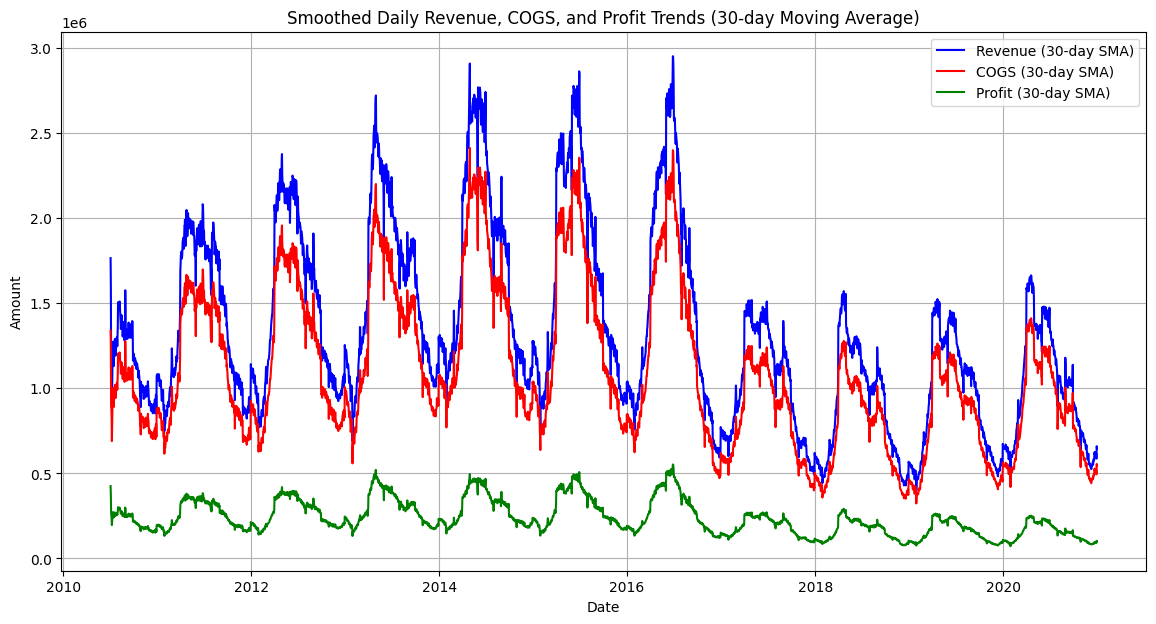

In [14]:
df_daily_filled['Revenue_SMA30'] = df_daily_filled['Revenue'].rolling(window=30, min_periods=1).mean()
df_daily_filled['COGS_SMA30'] = df_daily_filled['COGS'].rolling(window=30, min_periods=1).mean()
df_daily_filled['Profit_SMA30'] = df_daily_filled['Profit'].rolling(window=30, min_periods=1).mean()

plt.figure(figsize=(14, 7))

plt.plot(df_daily_filled['Date'], df_daily_filled['Revenue_SMA30'], label='Revenue (30-day SMA)', color='blue')
plt.plot(df_daily_filled['Date'], df_daily_filled['COGS_SMA30'], label='COGS (30-day SMA)', color='red')
plt.plot(df_daily_filled['Date'], df_daily_filled['Profit_SMA30'], label='Profit (30-day SMA)', color='green')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Smoothed Daily Revenue, COGS, and Profit Trends (30-day Moving Average)')
plt.legend()
plt.grid(True)
plt.show()


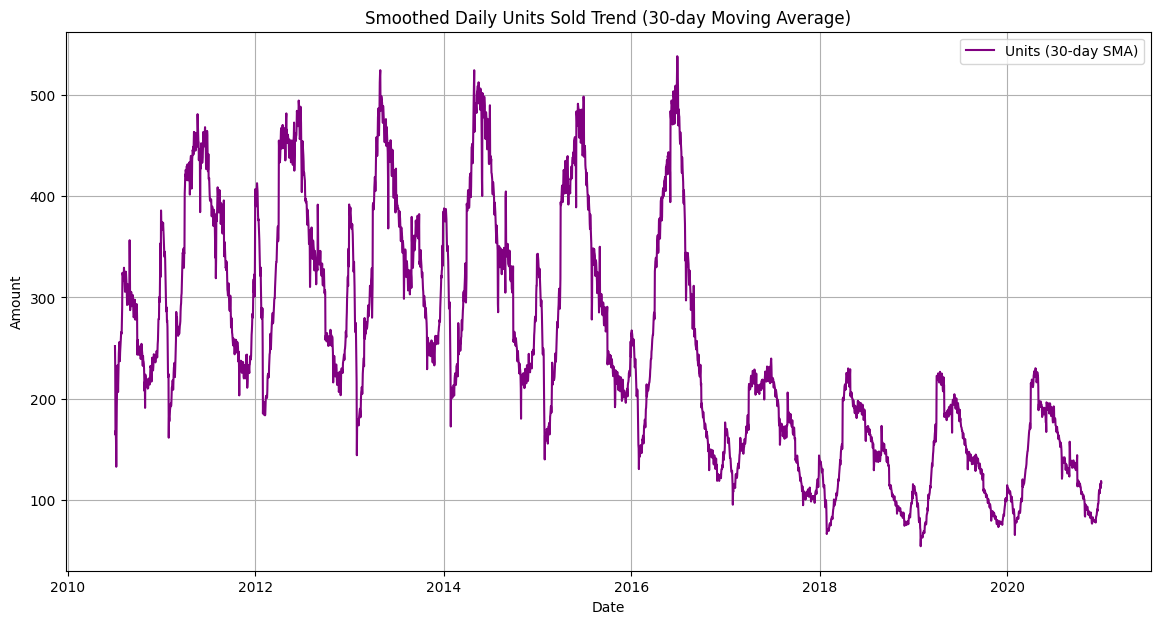

In [15]:
# Units theo ngày
df_daily_filled['Units_SMA30'] = df_daily_filled['Units'].rolling(window=30, min_periods=1).mean()

plt.figure(figsize=(14, 7))

plt.plot(df_daily_filled['Date'], df_daily_filled['Units_SMA30'], label='Units (30-day SMA)', color='purple')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Smoothed Daily Units Sold Trend (30-day Moving Average)')
plt.legend()
plt.grid(True)
plt.show()

## 2.3. Bảng thống kê theo tuần

In [16]:
# Tạo index cho việc resample
df_daily_filled.set_index('Date', inplace=True)

# Tổng hợp theo tuần
df_weekly = df_daily_filled.resample('W').sum()
df_weekly.reset_index(inplace=True)
df_weekly.head()

,Date,Revenue,COGS,Units,Profit,Revenue_SMA30,COGS_SMA30,Profit_SMA30,Units_SMA30
0,2010-07-04,1765391.67,1.340364e+06,252.0,4.250281e+05,1.765392e+06,1.340364e+06,4.250281e+05,252.000000
1,2010-07-11,7213720.50,5.695282e+06,1279.0,1.518438e+06,7.970410e+06,6.186540e+06,1.783870e+06,1211.470238
2,2010-07-18,9271698.03,7.354220e+06,1946.0,1.917479e+06,8.506952e+06,6.690945e+06,1.816007e+06,1554.831258
3,2010-07-25,8911026.18,7.123644e+06,2024.0,1.787383e+06,8.729338e+06,6.903888e+06,1.825451e+06,1733.792534
4,2010-08-01,12492317.25,1.009377e+07,2631.0,2.398548e+06,9.037231e+06,7.185980e+06,1.851251e+06,1875.832276


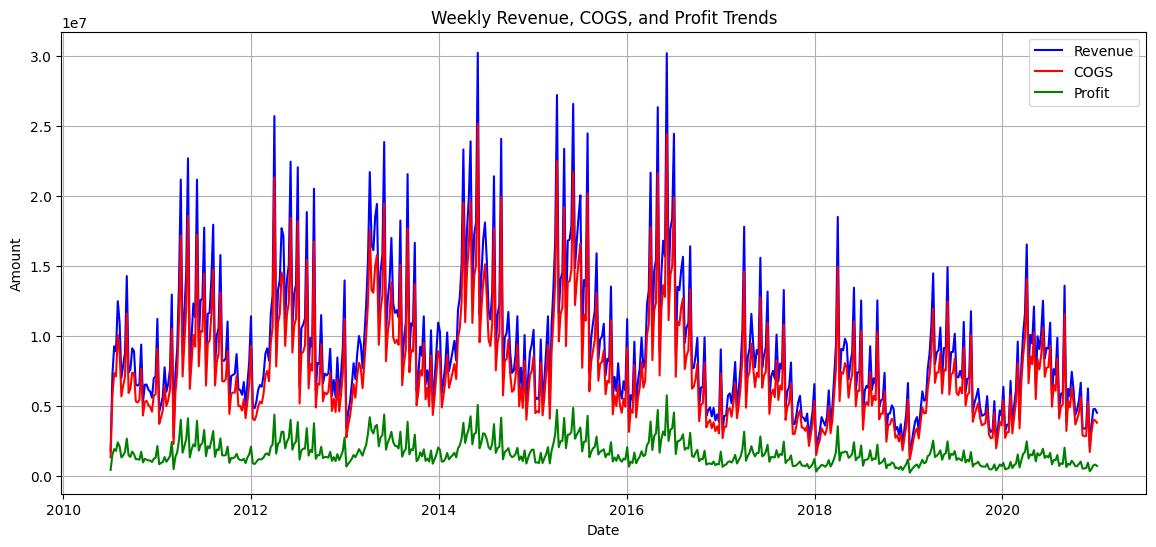

In [17]:
plt.figure(figsize=(14, 6))
plt.plot(df_weekly['Date'], df_weekly['Revenue'], label='Revenue', color='blue')
plt.plot(df_weekly['Date'], df_weekly['COGS'], label='COGS', color='red')
plt.plot(df_weekly['Date'], df_weekly['Profit'], label='Profit', color='green')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Weekly Revenue, COGS, and Profit Trends')
plt.legend()
plt.grid(True)
plt.show()

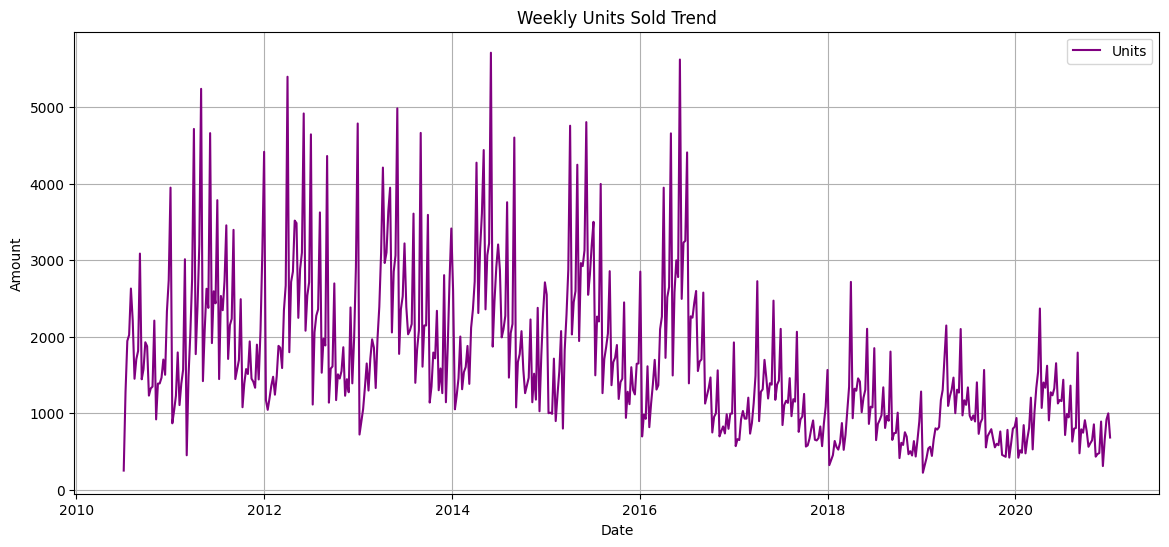

In [18]:
# Units theo tuần
plt.figure(figsize=(14, 6))
plt.plot(df_weekly['Date'], df_weekly['Units'], label='Units', color='purple')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Weekly Units Sold Trend')
plt.legend()
plt.grid(True)
plt.show()

## 2.4. Bảng thống kê theo tháng

In [19]:
df_monthly = df_daily_filled.resample('ME').sum()
df_monthly.reset_index(inplace=True)
df_monthly.head()

,Date,Revenue,COGS,Units,Profit,Revenue_SMA30,COGS_SMA30,Profit_SMA30,Units_SMA30
0,2010-07-31,36351952.56,2.894367e+07,7451.0,7.408282e+06,3.464194e+07,2.721781e+07,7.424128e+06,6337.497734
1,2010-08-31,47303856.18,3.832923e+07,9983.0,8.974624e+06,4.375226e+07,3.525243e+07,8.499833e+06,9718.477833
2,2010-09-30,34881766.29,2.837097e+07,7303.0,6.510792e+06,3.948921e+07,3.200540e+07,7.483805e+06,8630.220443
3,2010-10-31,32132565.36,2.628875e+07,6622.0,5.843811e+06,3.415087e+07,2.791788e+07,6.232992e+06,7396.864532
4,2010-11-30,27462497.58,2.245993e+07,6251.0,5.002569e+06,2.952830e+07,2.413469e+07,5.393608e+06,6630.229110


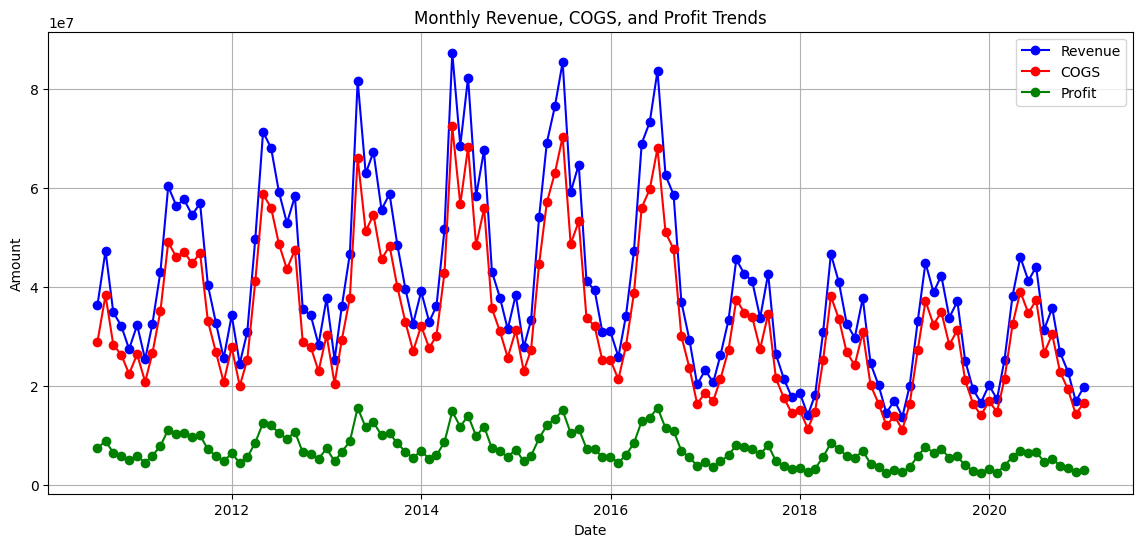

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(df_monthly['Date'], df_monthly['Revenue'], label='Revenue', color='blue', marker='o')
plt.plot(df_monthly['Date'], df_monthly['COGS'], label='COGS', color='red', marker='o')
plt.plot(df_monthly['Date'], df_monthly['Profit'], label='Profit', color='green', marker='o')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Monthly Revenue, COGS, and Profit Trends')
plt.legend()
plt.grid(True)
plt.show()

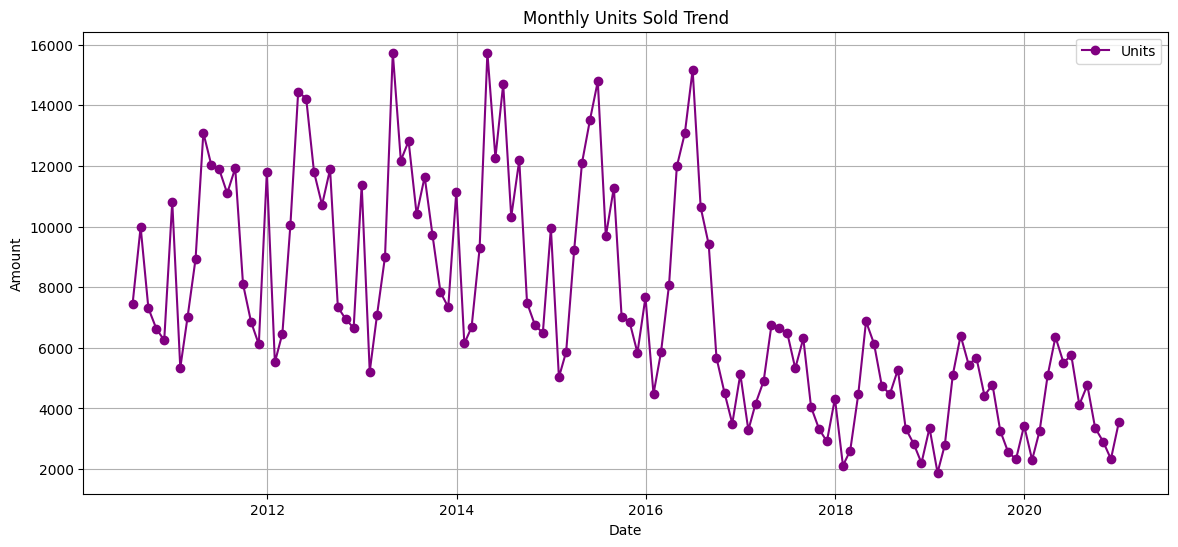

In [21]:
# Units theo tháng
plt.figure(figsize=(14, 6))

plt.plot(df_monthly['Date'], df_monthly['Units'], label='Units', color='purple', marker='o')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Monthly Units Sold Trend')
plt.legend()
plt.grid(True)
plt.show()

## 2.5. Bảng thống kê theo quý

In [22]:
df_quarterly = df_daily_filled.resample('QE').sum()
df_quarterly.reset_index(inplace=True)
df_quarterly.head()

,Date,Revenue,COGS,Units,Profit,Revenue_SMA30,COGS_SMA30,Profit_SMA30,Units_SMA30
0,2010-09-30,1.185376e+08,9.564388e+07,24737.0,2.289370e+07,1.178834e+08,9.447564e+07,2.340777e+07,24686.196010
1,2010-12-31,9.189888e+07,7.515457e+07,23687.0,1.674432e+07,9.191348e+07,7.520181e+07,1.671167e+07,22508.514410
2,2011-03-31,1.010592e+08,8.265671e+07,21280.0,1.840253e+07,9.363757e+07,7.655451e+07,1.708306e+07,24823.188262
3,2011-06-30,1.743700e+08,1.421848e+08,37000.0,3.218515e+07,1.735575e+08,1.415423e+08,3.201526e+07,40113.871756
4,2011-09-30,1.517744e+08,1.247447e+08,31128.0,2.702973e+07,1.568182e+08,1.287834e+08,2.803483e+07,33391.450912


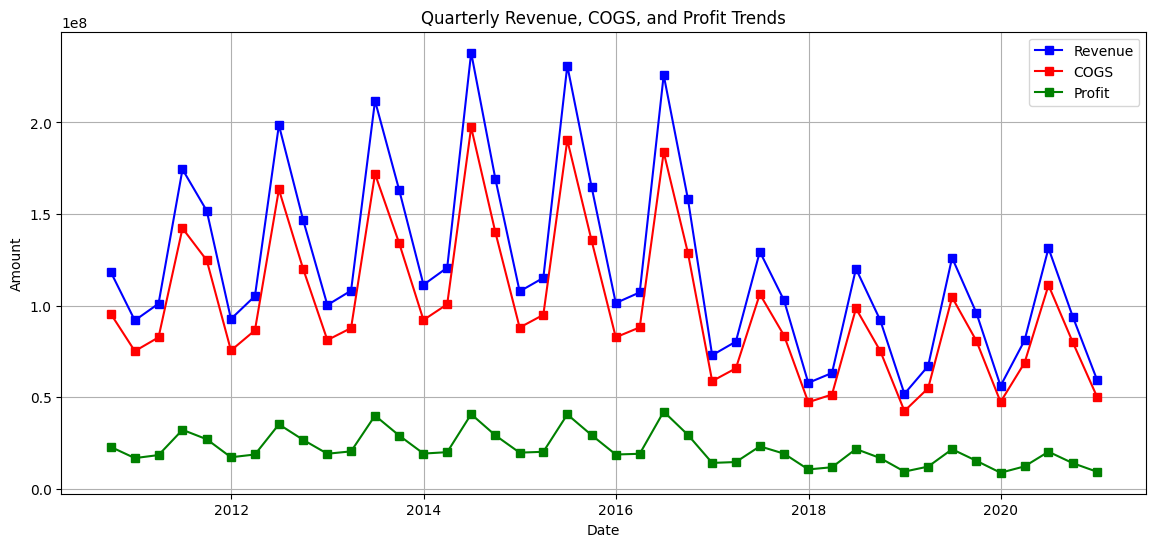

In [23]:
plt.figure(figsize=(14, 6))
plt.plot(df_quarterly['Date'], df_quarterly['Revenue'], label='Revenue', color='blue', marker='s')
plt.plot(df_quarterly['Date'], df_quarterly['COGS'], label='COGS', color='red', marker='s')
plt.plot(df_quarterly['Date'], df_quarterly['Profit'], label='Profit', color='green', marker='s')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Quarterly Revenue, COGS, and Profit Trends')
plt.legend()
plt.grid(True)
plt.show()


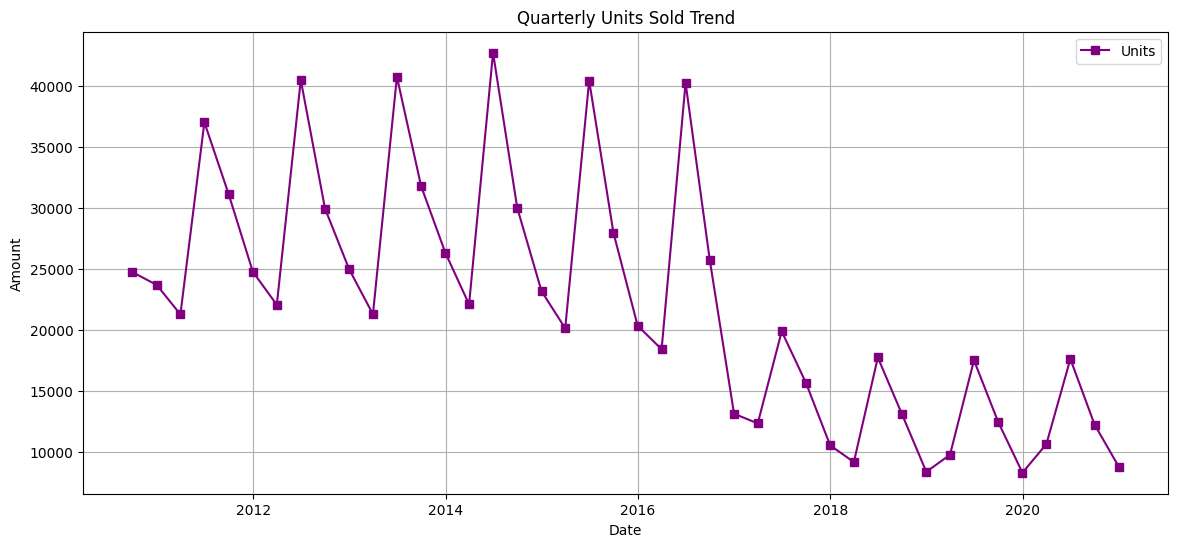

In [24]:
# Units theo quý
plt.figure(figsize=(14, 6))

plt.plot(df_quarterly['Date'], df_quarterly['Units'], label='Units', color='purple', marker='s')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Quarterly Units Sold Trend')
plt.legend()
plt.grid(True)
plt.show()

## 2.6. Bảng thống kê theo mùa

In [25]:
# Hàm xác định mùa dựa trên tháng
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Tạo cột Season và Year để nhóm theo mùa
df_daily_filled['Season'] = df_daily_filled.index.month.map(get_season)
df_daily_filled['Year'] = df_daily_filled.index.year

# Nhóm dữ liệu theo mùa và năm
df_seasonally = df_daily_filled.groupby(['Year', 'Season']).sum().reset_index()
df_seasonally.head()

,Year,Season,Revenue,COGS,Units,Profit,Revenue_SMA30,COGS_SMA30,Profit_SMA30,Units_SMA30
0,2010,Fall,9.447683e+07,7.711966e+07,20176.0,1.735717e+07,1.031684e+08,8.405798e+07,1.911040e+07,22657.314085
1,2010,Summer,8.365581e+07,6.727290e+07,17434.0,1.638291e+07,7.839420e+07,6.247024e+07,1.592396e+07,16055.975567
2,2010,Winter,3.230382e+07,2.640588e+07,10814.0,5.897938e+06,2.823430e+07,2.314923e+07,5.085068e+06,8481.420768
3,2011,Fall,9.880689e+07,8.080945e+07,21079.0,1.799744e+07,1.116397e+08,9.159430e+07,2.004538e+07,24117.645320
4,2011,Spring,1.597960e+08,1.302734e+08,34044.0,2.952253e+07,1.526608e+08,1.244863e+08,2.817454e+07,35933.859048


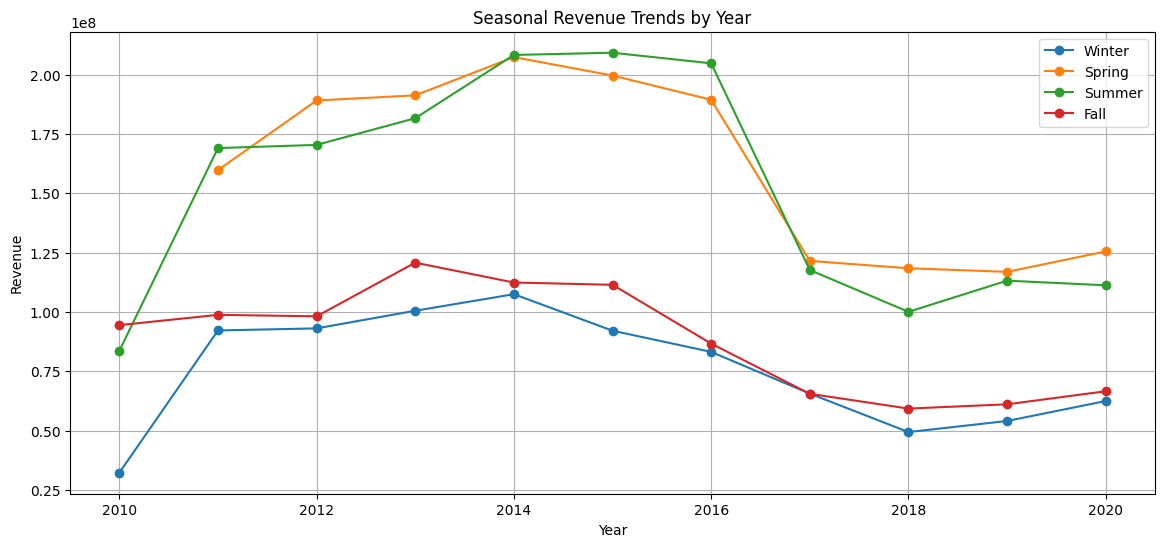

In [26]:
plt.figure(figsize=(14, 6))

for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    subset = df_seasonally[df_seasonally['Season'] == season]
    plt.plot(subset['Year'], subset['Revenue'], marker='o', label=season)

plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('Seasonal Revenue Trends by Year')
plt.legend()
plt.grid(True)
plt.show()

## 2.7. Bảng thống kê theo năm

In [27]:
df_yearly = df_daily_filled.resample('YE').sum()
# Xóa các cột không cần thiết
df_yearly.drop(columns=['Season'], inplace=True)
df_yearly.drop(columns=['Year'], inplace=True)

df_yearly.reset_index(inplace=True)
df_yearly.head()

,Date,Revenue,COGS,Units,Profit,Revenue_SMA30,COGS_SMA30,Profit_SMA30,Units_SMA30
0,2010-12-31,2.104365e+08,1.707984e+08,48424.0,3.963802e+07,2.097969e+08,1.696774e+08,4.011943e+07,47194.710420
1,2011-12-31,5.199015e+08,4.250785e+08,114179.0,9.482299e+07,5.183356e+08,4.238430e+08,9.449257e+07,121369.760383
2,2012-12-31,5.508145e+08,4.510869e+08,117427.0,9.972760e+07,5.492252e+08,4.499786e+08,9.924662e+07,123707.647861
3,2013-12-31,5.942496e+08,4.856279e+08,120105.0,1.086217e+08,5.927739e+08,4.841026e+08,1.086713e+08,123355.775433
4,2014-12-31,6.356110e+08,5.260177e+08,117966.0,1.095933e+08,6.363034e+08,5.267302e+08,1.095732e+08,121961.205747


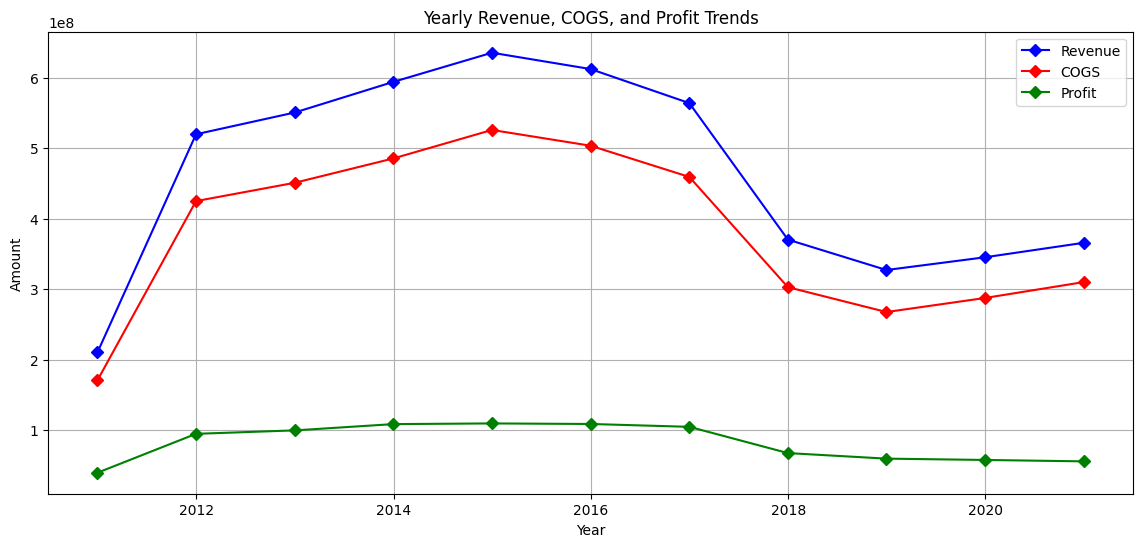

In [28]:
plt.figure(figsize=(14, 6))
plt.plot(df_yearly['Date'], df_yearly['Revenue'], label='Revenue', color='blue', marker='D')
plt.plot(df_yearly['Date'], df_yearly['COGS'], label='COGS', color='red', marker='D')
plt.plot(df_yearly['Date'], df_yearly['Profit'], label='Profit', color='green', marker='D')

plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Yearly Revenue, COGS, and Profit Trends')
plt.legend()
plt.grid(True)
plt.show()

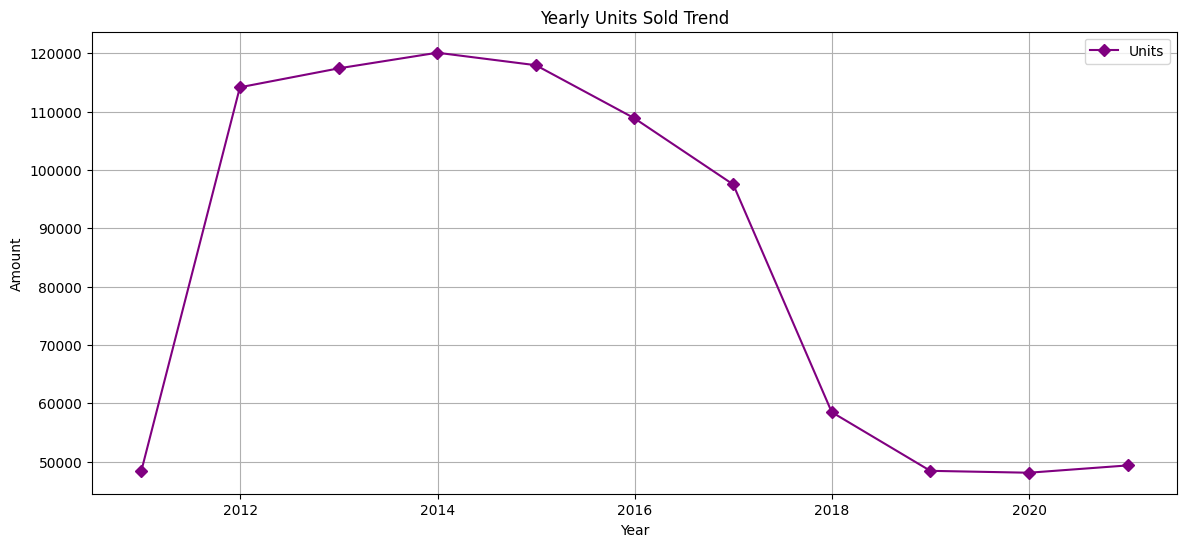

In [29]:
# Units theo năm
plt.figure(figsize=(14, 6))

plt.plot(df_yearly['Date'], df_yearly['Units'], label='Units', color='purple', marker='D')

plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Yearly Units Sold Trend')
plt.legend()
plt.grid(True)
plt.show()